In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from paretoset import paretoset
from scipy import stats
from scipy.special import rel_entr

In [2]:
SAMPLES = 100_000
BITS = 8
GAMMA_LOWER = 0.1
GAMMA_UPPER = 0.24
RESOLUTION = 256

cdf_xxis = np.linspace(GAMMA_LOWER, GAMMA_UPPER, RESOLUTION)
cdf_arr = stats.gamma.cdf(cdf_xxis, a=50, scale=1/311.44)

In [3]:
def remap(num, inMin, inMax, outMin, outMax):
  rv = outMin + (float(num - inMin) / float(inMax - inMin) * (outMax- outMin))
  # rv = outMin + round((float(num - inMin) / float(inMax - inMin) * (outMax- outMin)))
  return int(rv)

def get_pdf(type="exp"):
  if type == "exp":
    xxis = np.linspace(0, 255, 256)
    pdf = stats.gamma.pdf(xxis, a=1, scale=1/0.01)
    pdf = pdf/np.sum(pdf)
  elif type == "gamma":
    xxis = np.linspace(GAMMA_LOWER, GAMMA_UPPER, 256)
    pdf = stats.gamma.pdf(xxis, a=50, scale=1/311.44)
    pdf = pdf/np.sum(pdf)
  else:
    raise TypeError("Invalid pdf type")
  
  return xxis, pdf

def get_bits():
  cdf = lambda x: cdf_arr[round(remap(x, GAMMA_LOWER, GAMMA_UPPER, 0, len(cdf_arr)-1))]
  
  x2 = GAMMA_UPPER
  x0 = GAMMA_LOWER
  x1 = (x2+x0)/2
  number = 0
  bits = []

  for i in range(BITS):
    pright = (cdf(x2)-cdf(x1))/(cdf(x2)-cdf(x0))

    if pright == 0 or pright == 1:
      # x0 = stats.gamma.cdf(x0, a=50, scale=1/311.44)
      # x1 = stats.gamma.cdf(x1, a=50, scale=1/311.44)
      # x2 = stats.gamma.cdf(x2, a=50, scale=1/311.44)
      # pright = (x2-x1)/(x2-x0)

      print(f"x0: {x0}, x1: {x1}, x2: {x2}")
      print(f"x0_idx: {remap(x0, GAMMA_LOWER, GAMMA_UPPER, 0, len(cdf_arr)-1)}, x1_idx: {remap(x1, GAMMA_LOWER, GAMMA_UPPER, 0, len(cdf_arr)-1)}, x2_idx: {remap(x2, GAMMA_LOWER, GAMMA_UPPER, 0, len(cdf_arr)-1)}")
      print(f"my_cdf(x0): {cdf(x0)}, my_cdf(x1): {cdf(x1)}, my_cdf(x2): {cdf(x2)}")
      print(f"stat.gamma.cdf(x0): {stats.gamma.cdf(x0, a=50, scale=1/311.44)}, stat.gamma.cdf(x1): {stats.gamma.cdf(x1, a=50, scale=1/311.44)}, stat.gamma.cdf(x2): {stats.gamma.cdf(x2, a=50, scale=1/311.44)}")
      print(f"({cdf(x2)} - {cdf(x1)}) / ({cdf(x2)} - {cdf(x0)}) = {pright}")
      print(f"{cdf(x2)-cdf(x1)} / {cdf(x2)-cdf(x0)} = {pright}")
    
    if random.random() < pright:
      out = 1
      x0 = x1
    else:
      out = 0
      x2 = x1
  
    x1 = (x2+x0)/2
    number += out*2**(BITS-i-1)
    bits.append(out)

    if pright == 0 or pright == 1:
      print(bits)
      print()

  return number, bits

In [4]:
num_history = []
bit_history = []

for i in range(SAMPLES):
  num, bit = get_bits()
  num_history.append(num)
  bit_history.append(bit)

x0: 0.1, x1: 0.10054687500000001, x2: 0.10109375000000001
x0_idx: 0, x1_idx: 0, x2_idx: 1
my_cdf(x0): 0.0011287838504697313, my_cdf(x1): 0.0011287838504697313, my_cdf(x2): 0.0012605753595271334
stat.gamma.cdf(x0): 0.0011287838504697313, stat.gamma.cdf(x1): 0.0012600352660656414, stat.gamma.cdf(x2): 0.001404537779274868
(0.0012605753595271334 - 0.0011287838504697313) / (0.0012605753595271334 - 0.0011287838504697313) = 1.0
0.00013179150905740216 / 0.00013179150905740216 = 1.0
[0, 0, 0, 0, 0, 0, 0, 1]

x0: 0.1, x1: 0.10054687500000001, x2: 0.10109375000000001
x0_idx: 0, x1_idx: 0, x2_idx: 1
my_cdf(x0): 0.0011287838504697313, my_cdf(x1): 0.0011287838504697313, my_cdf(x2): 0.0012605753595271334
stat.gamma.cdf(x0): 0.0011287838504697313, stat.gamma.cdf(x1): 0.0012600352660656414, stat.gamma.cdf(x2): 0.001404537779274868
(0.0012605753595271334 - 0.0011287838504697313) / (0.0012605753595271334 - 0.0011287838504697313) = 1.0
0.00013179150905740216 / 0.00013179150905740216 = 1.0
[0, 0, 0, 0, 0, 

In [5]:
# Build gamma distribution
xxis, pdf = get_pdf("gamma")

# Calculate chi2
counts, _ = np.histogram(num_history, bins=256)
pdf = pdf*SAMPLES
chi2 = 0
for j in range(256):
  chi2 += ((counts[j]-pdf[j])**2)/pdf[j]
counts = counts/SAMPLES
pdf = pdf/SAMPLES

# Calculate KL-Div
kl_div_score = sum(rel_entr(counts, pdf))

print("Chi2  :", chi2)
print("KL_Div:", kl_div_score)

Chi2  : 1122.0590068848617
KL_Div: 0.009804174875648396


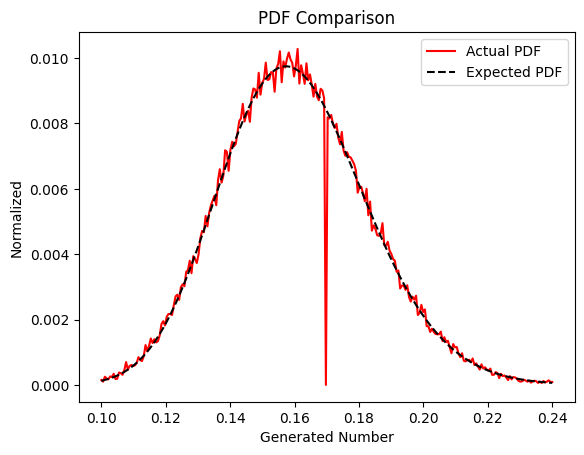

In [6]:
plt.plot(xxis, counts, color="red", label="Actual PDF")
plt.plot(xxis, pdf,'k--', label="Expected PDF")
plt.xlabel("Generated Number")
plt.ylabel("Normalized")
plt.title("PDF Comparison")
plt.legend()
plt.show()

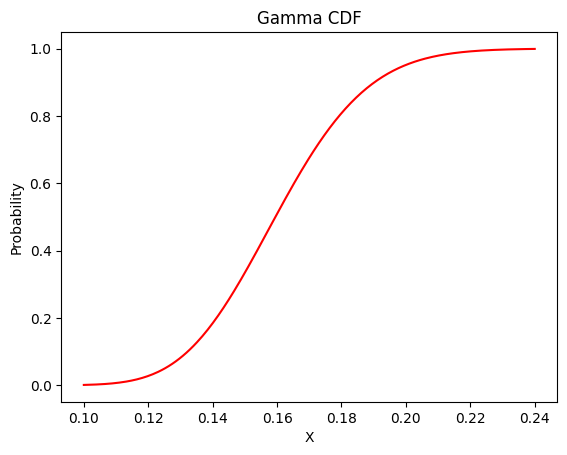

In [7]:
plt.plot(cdf_xxis, cdf_arr, color="red")
plt.xlabel("X")
plt.ylabel("Probability")
plt.title("Gamma CDF")
plt.show()

In [8]:
x = 0.12625

print(remap(x, GAMMA_LOWER, GAMMA_UPPER, 0, len(cdf_arr)-1))
print(round(remap(x, GAMMA_LOWER, GAMMA_UPPER, 0, len(cdf_arr)-1)))

47
47
